<a href="https://colab.research.google.com/github/aghosh92/ELIT_tutorial/blob/main/ELIT_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learning Iterative Training (ELIT)

**System**: Graphene with impurities

**STEM experiment:** by Ondrej Dyck

**Molecular Dynamics (MD) Simulations** by Bobby Sumpter and Ayana Ghosh

**Machine Learning Framework, implementation and models development** by Maxim Ziatdinov, Sergei V. Kalinin

**Notebook Preparation and models training** by Ayana Ghosh

---


The goal of this study is to show how the ensemble learning and iterative training (ELIT) framework can be used for iteratively adapting model(s) trained on simulated data to real-world experimental images.

0. Train ensemble of models using MD-simulated data of graphene at 300 K. No impurities or amorphous parts were present in the supercells of graphene.

1.   Apply the trained ensemble of models to experimental data and compare results between different models.

2.   The best ensemble model is then applied to an experimental graphene movie for locating atoms, with (optional) postporcessing for separating lattice and amorphous phases via Gaussian Mixture Model (GMM).

3. The new ensemble is trained using a "good" (artifact-free) portion of results from (2), which is the first *n* frames of the entire movie (*n* = 6, 21). Once trained, it is used on all the remaining frames (not used for training) to obtain accurate pixel-wise classification of the entire dataset.

4. The information about atomic positions (obtained in (3)) and the corresponding raw pixel intensities is used to creat multi-class labels (segmentation masks) and (re)train the ensemble of models on the multi-class data to categorize each pixel as belogning to lattice C atoms, impurities, or background.


---





If you would like to retrain the models (instead of using the ones provided), it may be a good idea to mount a google drive so that the models can be stored there during and at the end of training.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install AtomAI:

In [2]:
#@title Install libraries
!pip install atomai
!pip install wget

     |████████████████████████████████| 133kB 12.8MB/s 
     |████████████████████████████████| 194kB 9.4MB/s 
     |████████████████████████████████| 870kB 18.7MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174964 sha256=00731c329626aab194d746bdb6a472b1893bbab77ee4aec48954815a085cbb44
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b0139a692f6c265d399cab3aa097
Successfully built mendeleev
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=d4a2931190c1035d180c967820d7d0a6b6cd95ab4a2c7c35c7f35c0bdd1c606f
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


Import essential packages:

In [3]:
import atomai as aoi
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy as dc
import torch
from skimage import io
from sklearn.model_selection import train_test_split

from atomai.utils import (cv_thresh, find_com, get_downsample_factor,
                          get_nb_classes, img_pad, img_resize, peak_refinement,
                          set_train_rng, torch_format_image,
                          torch_format_spectra)

import time
from typing import Dict, List, Tuple, Type, Union

from skimage import data, feature, exposure
import wget

In [4]:
import wget

Load experimental data (we are going to need it many times throughout this notebook):

In [5]:
#@title Download image data
#!gdown https://drive.google.com/uc?id=1lY-_IfKIn-srJAWNx24bHUL1ldniow80

!gdown https://drive.google.com/uc?id=1VmZLVeA-2QnbSeqRrUG9VNMDQ3hLPmAJ

Downloading...
From: https://drive.google.com/uc?id=1VmZLVeA-2QnbSeqRrUG9VNMDQ3hLPmAJ
To: /content/3D Stack8 10nmfov.tif
420MB [00:03, 106MB/s]


(100, 896, 896)


(-0.5, 895.5, -0.5, 895.5)

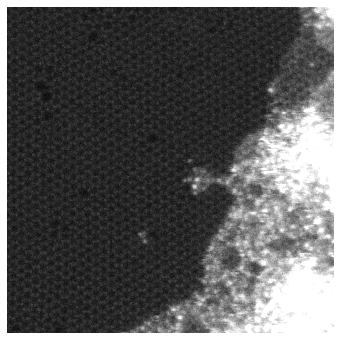

In [6]:
filename = "3D Stack8 10nmfov.tif"
imgdata = io.imread(filename)[:, 128:, 128:] # get rid of the "fly-back delay" part
print(imgdata.shape)

plt.figure(figsize=(6, 6))
plt.imshow(imgdata[0], origin="lower", cmap='gray', vmin=0, vmax=0.7)
plt.axis('off')

In [7]:
#@title Backup Link
#Dropbox link
#!wget -O 3D_Stack8_10nmfov.tif https://www.dropbox.com/s/3e73je7pahbywiz/3D_Stack8_10nmfov.tif?dl=0

# filename = "3D_Stack8_10nmfov.tif"
# imgdata = io.imread(filename)[:, 128:, 128:] # get rid of the "fly-back delay" part
# print(imgdata.shape)

# plt.figure(figsize=(6, 6))
# plt.imshow(imgdata[0], origin="lower", cmap='gray', vmin=0, vmax=0.7)
# plt.axis('off')

We start by training an ensemble of models from which we are going to select the basline model(s). Note that once trained, you can skip this part and focus on the iterative training part.

Load (clean) data created from MD simulations:

In [8]:
!gdown https://drive.google.com/uc?id=1-zi5kHeEpcGLHr4XJDJcC7kfawwfTVAj
!gdown https://drive.google.com/uc?id=1-0hsxCP314pC1n9Ywz_WppWhscuT_gGI

Downloading...
From: https://drive.google.com/uc?id=1-zi5kHeEpcGLHr4XJDJcC7kfawwfTVAj
To: /content/cropped_images_new.npy
3.17GB [00:27, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0hsxCP314pC1n9Ywz_WppWhscuT_gGI
To: /content/cropped_masks_new.npy
3.17GB [00:36, 87.1MB/s]


In [9]:
#@title Backup links
#Dropbox link
# !wget -O cropped_images_new.npy https://www.dropbox.com/s/y3fooyw7l96q53a/cropped_images_new.npy?dl=0
# !wget -O cropped_masks_new.npy https://www.dropbox.com/s/iz6bwy4mmxhuybp/cropped_masks_new.npy?dl=0

In [10]:
X_train = np.load('cropped_images_new.npy')
y_train = np.load('cropped_masks_new.npy')
print(X_train.shape, y_train.shape)

(6046, 256, 256) (6046, 256, 256)


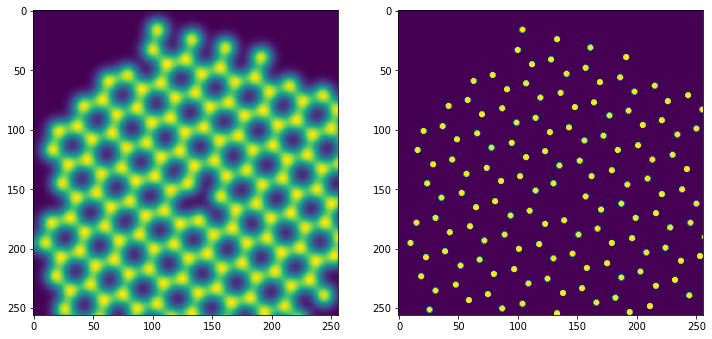

In [11]:
k = 35

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(X_train[k])
ax2.imshow(y_train[k])

Augment data so that the trained models can generalize to real experimental data:

In [12]:
dt = aoi.transforms.datatransform(1, # number of classes
                                  gauss_noise=[2000, 3000], # scaled values
                                  poisson_noise=[30, 45],
                                  blur=False,
                                  contrast=True,
                                  zoom=True,
                                  resize=[2, 1], # downsize all the images by a factor of 2
                                  seed=1)

X_train, y_train = dt.run(X_train, y_train[..., None])

Train ensemble of model starting evey time with dfifferent (randomly initialized weights)

Downloading...
From: https://drive.google.com/uc?id=144GFPptAphHlUOVgRX7_ZeNIPjXcVyKb
To: /content/graphene_md_dilUnet2_ensemble.tar
1.07GB [00:12, 88.1MB/s]
Training ensemble models (strategy = 'from_scratch')

Ensemble model 1
Epoch 1/1 ... Training loss: 0.8721 ... Test loss: 0.6712 ... GPU memory usage: 9523/16160
Model (final state) evaluation loss: 0.6713
Plotting training history


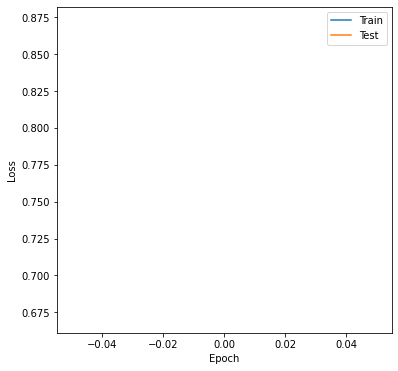


Ensemble model 2
Epoch 1/1 ... Training loss: 0.8691 ... Test loss: 0.6927 ... GPU memory usage: 9551/16160
Model (final state) evaluation loss: 0.6927
Plotting training history


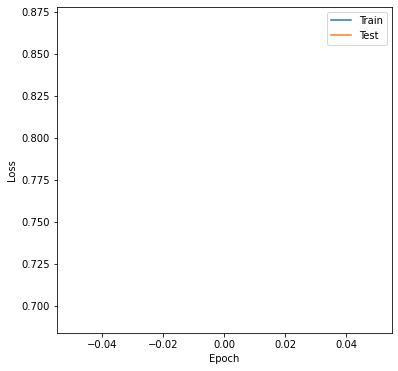


Ensemble model 3
Epoch 1/1 ... Training loss: 0.9182 ... Test loss: 0.6647 ... GPU memory usage: 9515/16160
Model (final state) evaluation loss: 0.6648
Plotting training history


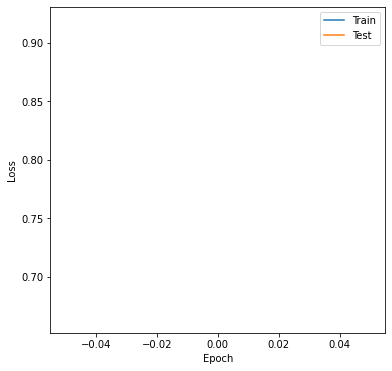


Ensemble model 4
Epoch 1/1 ... Training loss: 0.9168 ... Test loss: 0.6767 ... GPU memory usage: 9551/16160
Model (final state) evaluation loss: 0.6768
Plotting training history


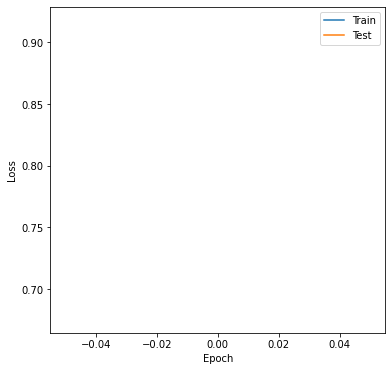


Ensemble model 5
Epoch 1/1 ... Training loss: 0.8788 ... Test loss: 0.6582 ... GPU memory usage: 9555/16160
Model (final state) evaluation loss: 0.6583
Plotting training history


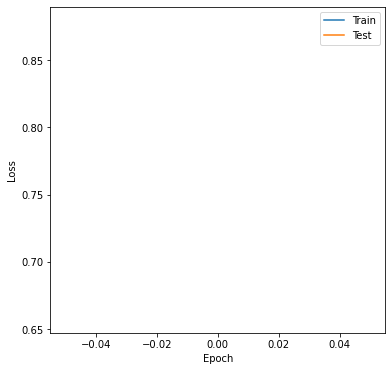


Ensemble model 6
Epoch 1/1 ... Training loss: 0.8623 ... Test loss: 0.6858 ... GPU memory usage: 9651/16160
Model (final state) evaluation loss: 0.6858
Plotting training history


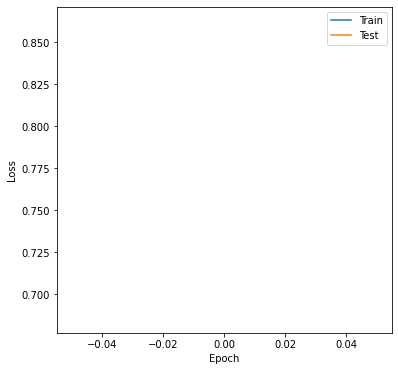


Ensemble model 7
Epoch 1/1 ... Training loss: 0.9047 ... Test loss: 0.6738 ... GPU memory usage: 9655/16160
Model (final state) evaluation loss: 0.6739
Plotting training history


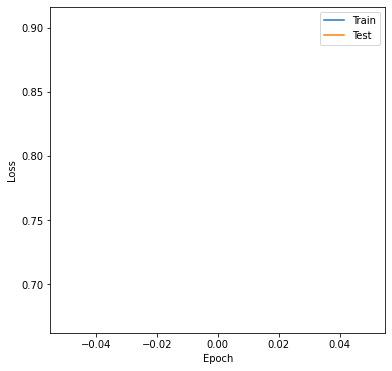


Ensemble model 8
Epoch 1/1 ... Training loss: 0.8961 ... Test loss: 0.6701 ... GPU memory usage: 9751/16160
Model (final state) evaluation loss: 0.6702
Plotting training history


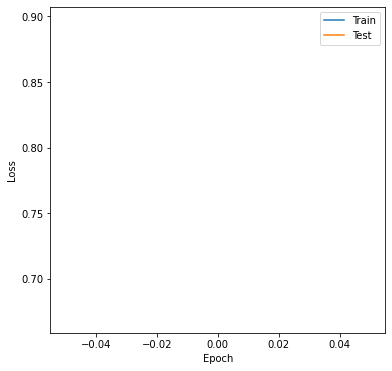


Ensemble model 9
Epoch 1/1 ... Training loss: 0.9144 ... Test loss: 0.6634 ... GPU memory usage: 9757/16160
Model (final state) evaluation loss: 0.6635
Plotting training history


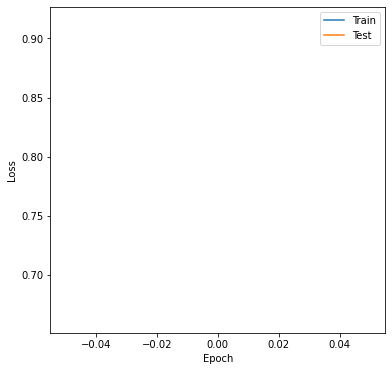


Ensemble model 10
Epoch 1/1 ... Training loss: 0.8539 ... Test loss: 0.6805 ... GPU memory usage: 9857/16160
Model (final state) evaluation loss: 0.6806
Plotting training history


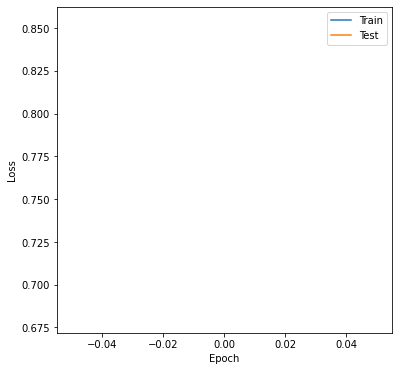


Ensemble model 11
Epoch 1/1 ... Training loss: 0.9261 ... Test loss: 0.686 ... GPU memory usage: 9885/16160
Model (final state) evaluation loss: 0.6861
Plotting training history


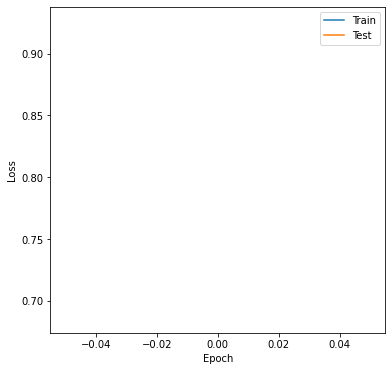


Ensemble model 12
Epoch 1/1 ... Training loss: 0.9227 ... Test loss: 0.6732 ... GPU memory usage: 9965/16160
Model (final state) evaluation loss: 0.6733
Plotting training history


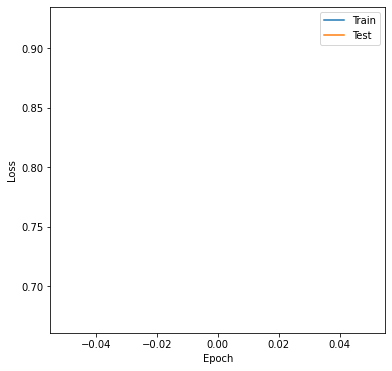


Ensemble model 13
Epoch 1/1 ... Training loss: 0.8828 ... Test loss: 0.678 ... GPU memory usage: 9993/16160
Model (final state) evaluation loss: 0.6781
Plotting training history


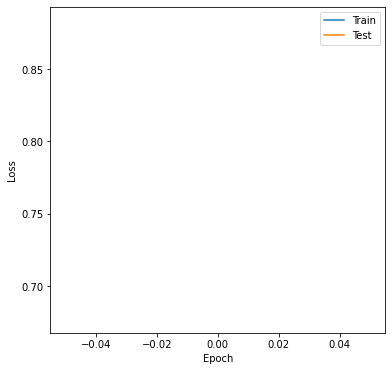


Ensemble model 14
Epoch 1/1 ... Training loss: 0.8697 ... Test loss: 0.6834 ... GPU memory usage: 10073/16160
Model (final state) evaluation loss: 0.6834
Plotting training history


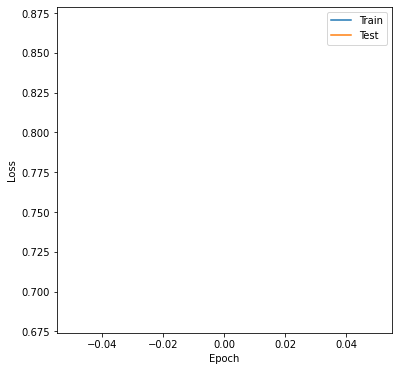


Ensemble model 15
Epoch 1/1 ... Training loss: 0.8954 ... Test loss: 0.6854 ... GPU memory usage: 10101/16160
Model (final state) evaluation loss: 0.6854
Plotting training history


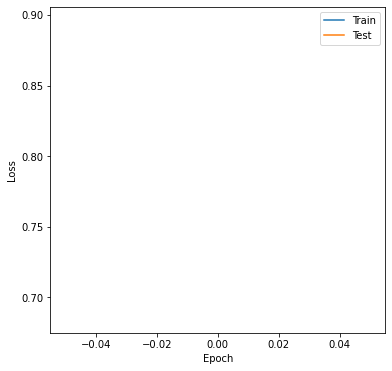


Ensemble model 16
Epoch 1/1 ... Training loss: 0.8701 ... Test loss: 0.6517 ... GPU memory usage: 10181/16160
Model (final state) evaluation loss: 0.6519
Plotting training history


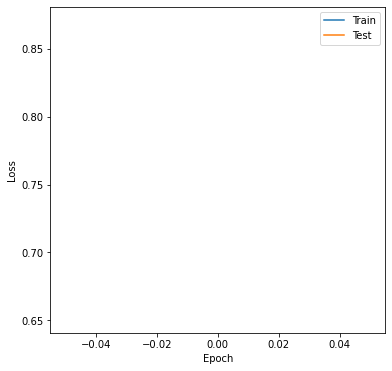


Ensemble model 17
Epoch 1/1 ... Training loss: 0.9247 ... Test loss: 0.6868 ... GPU memory usage: 10225/16160
Model (final state) evaluation loss: 0.6868
Plotting training history


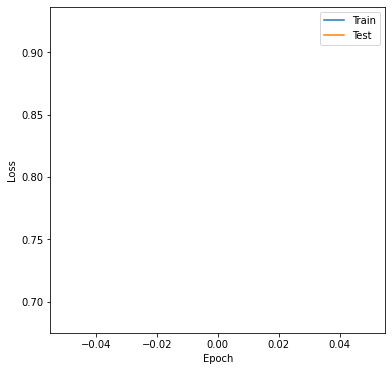


Ensemble model 18
Epoch 1/1 ... Training loss: 0.8891 ... Test loss: 0.6925 ... GPU memory usage: 10269/16160
Model (final state) evaluation loss: 0.6925
Plotting training history


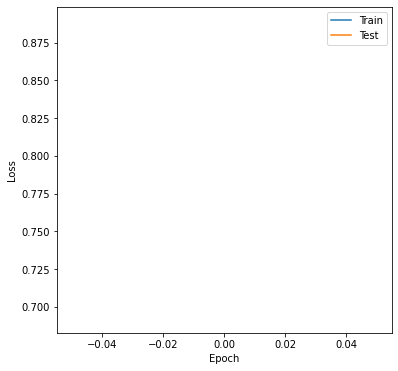


Ensemble model 19
Epoch 1/1 ... Training loss: 0.8654 ... Test loss: 0.6897 ... GPU memory usage: 10333/16160
Model (final state) evaluation loss: 0.6897
Plotting training history


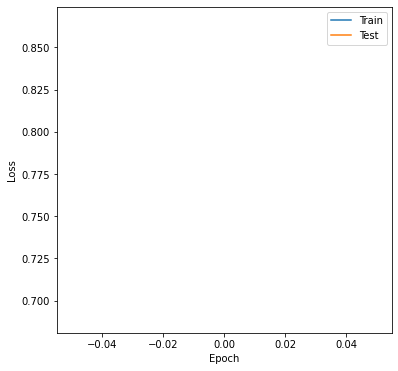


Ensemble model 20
Epoch 1/1 ... Training loss: 0.9007 ... Test loss: 0.6771 ... GPU memory usage: 10377/16160
Model (final state) evaluation loss: 0.6772
Plotting training history


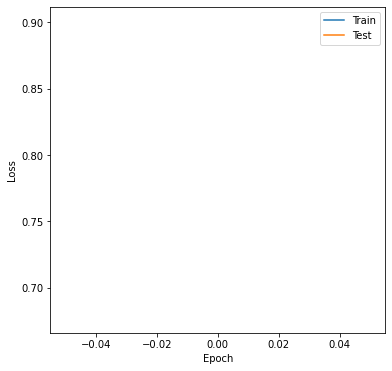

In [15]:
train_new = False

if train_new:
  etrainer = aoi.trainers.EnsembleTrainer("Unet", nb_classes=1, with_dilation=False,
                                      batch_norm=True, nb_filters=64, layers=[2, 3, 3, 4])
  etrainer.compile_ensemble_trainer(training_cycles=2000,compute_accuracy=True, swa=True, memory_alloc=0.5)
  smodel, ensemble = etrainer.train_ensemble_from_scratch(X_train, y_train, n_models=20)

else:
  #!gdown https://drive.google.com/uc?id=1gNHnH4l_Yll6PFP_rlA0emMNKhU2RtIo
  !gdown https://drive.google.com/uc?id=144GFPptAphHlUOVgRX7_ZeNIPjXcVyKb
  #!wget -O graphene_md_dilUnet2_ensemble.tar https://www.dropbox.com/s/ash6btishvzvpi4/graphene_md_dilUnet2_ensemble.tar?dl=0
  
  #Adapt to the Atom AI new version

  # Initalize ensemble trainer and do a "fake" training for just 1 iteration using the newest atomai version

  etrainer = aoi.trainers.EnsembleTrainer("Unet", nb_classes=1, with_dilation=False,
                                          batch_norm=True, nb_filters=64, layers=[2, 3, 3, 4])

  etrainer.compile_ensemble_trainer(training_cycles=1)

  smodel, ensemble = etrainer.train_ensemble_from_scratch(X_train, y_train, n_models=20, filename="/content/new")


  # Load weights from the old model and put into the new ensemble format

  ensemble_old = torch.load("graphene_md_dilUnet2_ensemble.tar")["weights"]

  for i in range(len(ensemble)):
      ensemble[i] = ensemble_old[i]

  etrainer.save_ensemble_metadict()

  # load back the ensemble with new weigths:
  smodel, ensemble = aoi.models.load_ensemble("/content/new_ensemble_metadict.tar")

Apply each model from ensemble trained on simulated data to the real experimental data data:

Batch 1/1

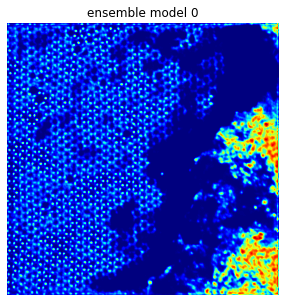

Batch 1/1

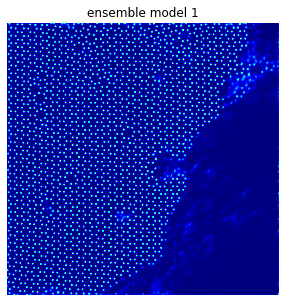

Batch 1/1

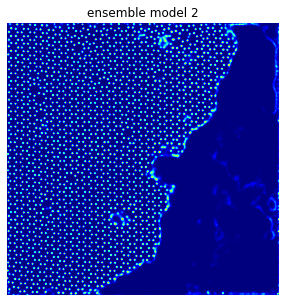

Batch 1/1

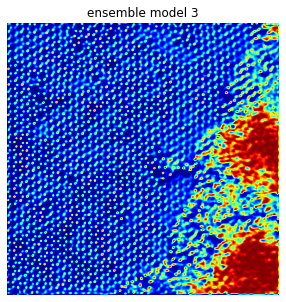

Batch 1/1

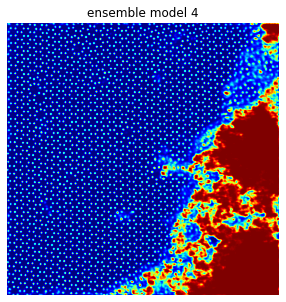

Batch 1/1

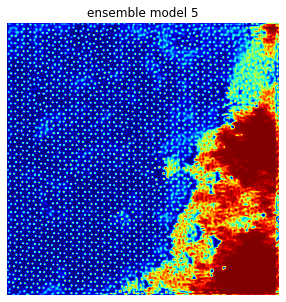

Batch 1/1

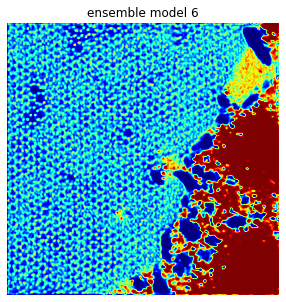

Batch 1/1

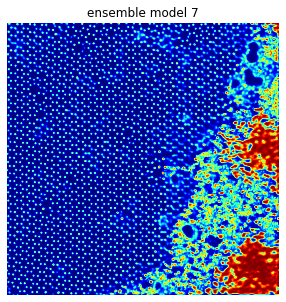

Batch 1/1

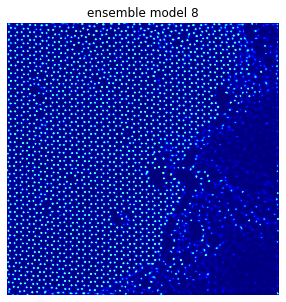

Batch 1/1

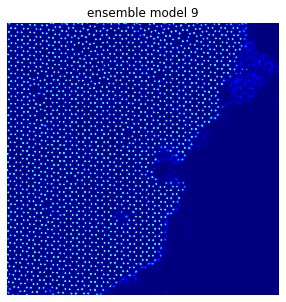

Batch 1/1

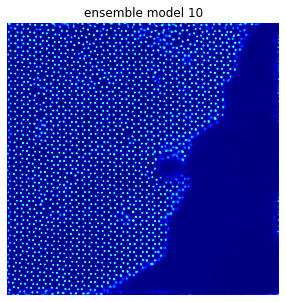

Batch 1/1

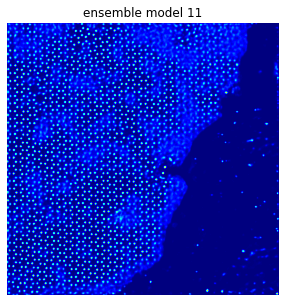

Batch 1/1

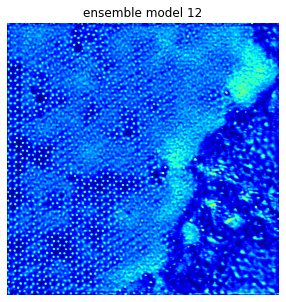

Batch 1/1

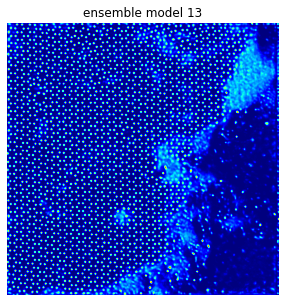

Batch 1/1

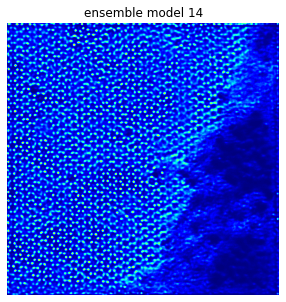

Batch 1/1

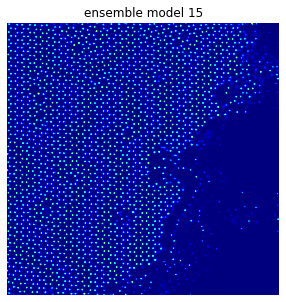

Batch 1/1

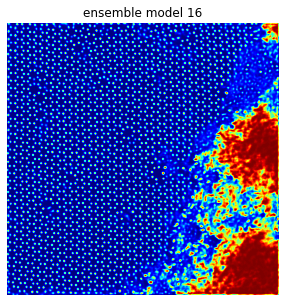

Batch 1/1

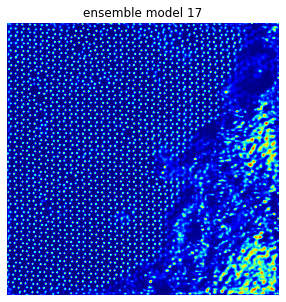

Batch 1/1

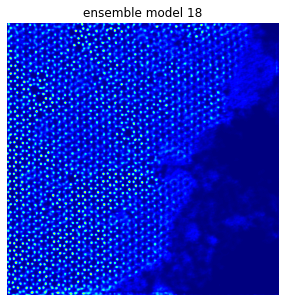

Batch 1/1

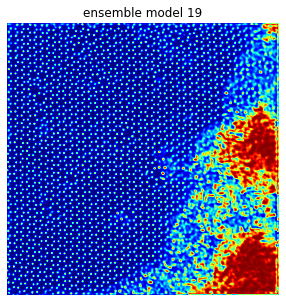

In [16]:
for i, m in enumerate(ensemble.values()):
    smodel.load_state_dict(m)
    p = aoi.predictors.SegPredictor(smodel, use_gpu=True)
    nn_out = p.predict(imgdata[0])
    plt.figure(figsize=(5, 5))
    plt.imshow(nn_out[0,...,0], origin="lower", cmap='jet', interpolation="Gaussian")
    plt.title("ensemble model {}".format(i))
    plt.axis('off')
    plt.show()

Choose and load the best ensemble model.

Here, ensemble model 19 is chosen here for the subsequent analyses.

In [17]:
smodel.load_state_dict(ensemble[19])

<All keys matched successfully>

In [18]:
decoded_imgs, coordinates = aoi.predictors.SegPredictor(smodel, use_gpu=True).run(imgdata)

Batch 100/100
100 images were decoded in approximately 18.1194 seconds


View predictions on selected frames:

Text(0.5, 1.0, 'Frame 90')

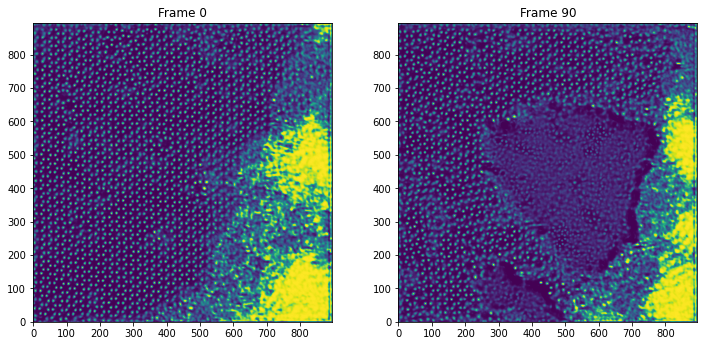

In [19]:
k1, k2 = 0, 90 # frame at the beginning and at the end of STEM movie
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))
ax1.imshow(decoded_imgs[0,...,0], origin="lower")
ax1.set_title("Frame {}".format(k1))
ax2.imshow(decoded_imgs[90,...,0], origin="lower")
ax2.set_title("Frame {}".format(k2))

This function separates into 2 classes (lattice & amorphous) using GMM:

In [20]:
def gmm_classify(coord_dict_pred):
  coordinates = aoi.stat.update_classes(coord_dict_pred, imgdata, method="gmm_local",
    n_components=2, window_size=48, coord_class=0) # other methods: kmeans, meanshift, threshold
  return coordinates

Here we use GMM classification to separate amorphous part from the lattice. Hence, before using the GMM classification, it is important to check if there is both lattice & amorphous phase shown by the ensemble model. 

As an example, ensemble model 19 shows both lattice and amorphous phase in the initial prediction. Therefore, the user has chosen 'Y' (yes) for this optional step.

Can you see both lattice & amorphous phase generated by the model you just loaded ? Y or N   
Y
  

Your answer is: Y
Please execute the following steps before moving on to Iterative Training 00 cell.


/usr/local/lib/python3.7/dist-packages/atomai/stat/multivar.py:94: UserWarning: The crop_size argument is deprecated. Use window_size to specify size of subimages
  UserWarning)



GMM components


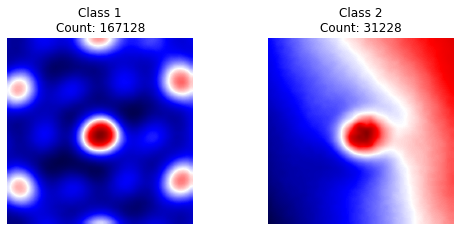

In [21]:
text = input('Can you see both lattice & amorphous phase generated by the model you just loaded ? Y or N   \n')
print("  \n")
print("Your answer is:",text)
if text == 'Y':
  print('Please execute the following steps before moving on to Iterative Training 00 cell.')
  #gmm classification
  coordinates = gmm_classify(coordinates)
else:
  print('Please skip the following steps and jump to cell named Iterative Training 00 cell.')

Here one component clearly corresponds to the amorphous phase and another one to the lattice.

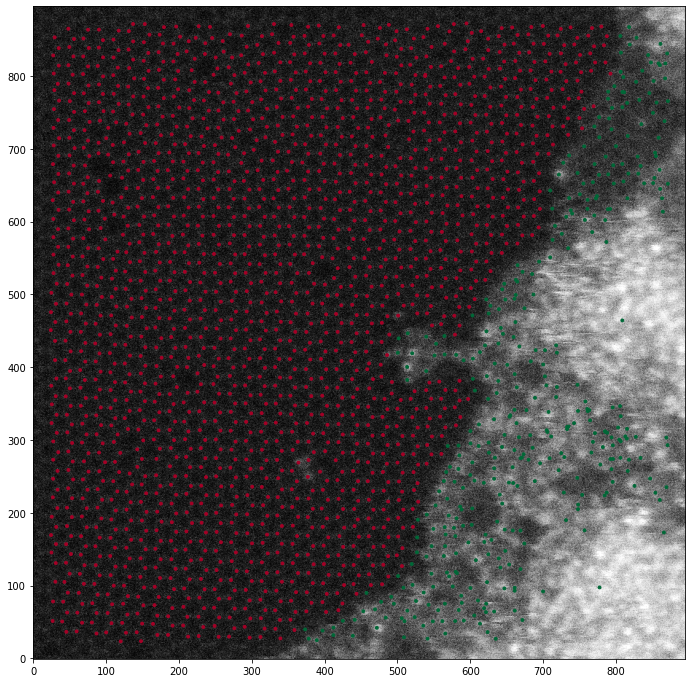

In [22]:
# Plot results
k = 0 # frame number
aoi.utils.plot_coord(imgdata[k, ...], coordinates[k], fsize=12)

Now let's filter out the coordinates corresponding to the amorphous phase:

In [23]:
coordinates_filtered = {}
for k, c in coordinates.items():
    coordinates_filtered[k] = c[c[:, -1] == 0] # adjust the "amorphous phase" class (0 or 1) if necessary

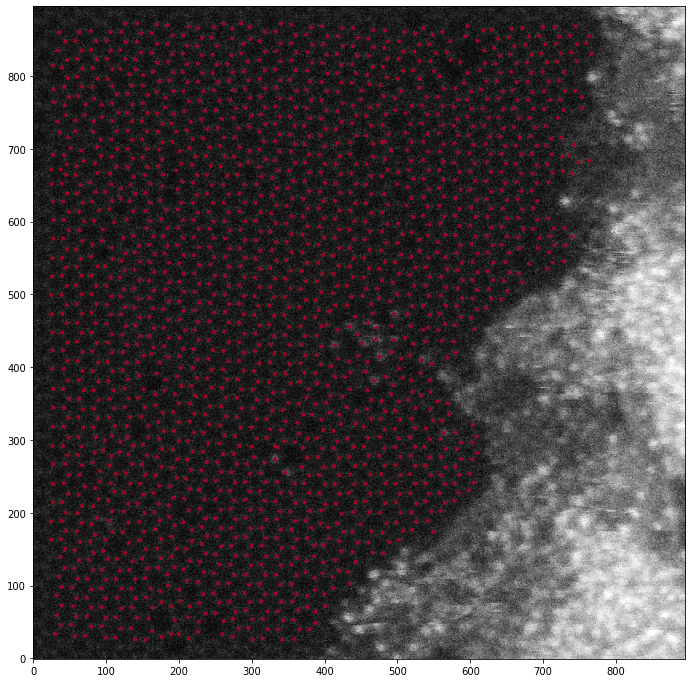

In [24]:
# Plot results
k = 20 # frame number
aoi.utils.plot_coord(imgdata[k, ...], coordinates_filtered[k], fsize=12)

### Iterative training 00: Adapting to experimental data

Now let's train a more narrowly-focused NN using the previous NN as a baseline. First we need to create a new training set. this time from the experimental data. Here we will use the same idea as in our [earlier work](https://www.nature.com/articles/s41524-019-0152-9) that for the movies of atomic transformations it is sufficient to train NN only on the first several frames where the positions are well defined (low degree of disorder) and we can easily label them.

Create ground truth for iterative training:

In [25]:
masks = np.zeros((21, *imgdata.shape[1:]))
for i in range(21):
    masks[i] = aoi.utils.create_lattice_mask(imgdata[i], coordinates_filtered[i][:, :-1])

In [26]:
X_train, y_train = aoi.utils.extract_patches(imgdata[:21], masks, patch_size=224, num_patches=200)
print(X_train.shape, y_train.shape)

(4200, 224, 224) (4200, 224, 224)


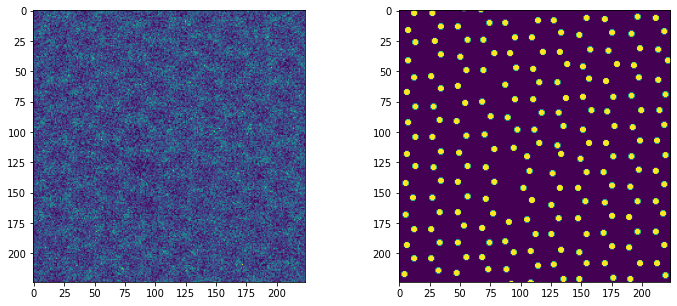

In [27]:
k = 600
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(X_train[k])
ax2.imshow(y_train[k])

In [28]:
add_noise = True

if add_noise:

    dt = aoi.transforms.datatransform(1, # number of classes
                                    gauss_noise=[0, 100], # scaled values
                                    #contrast=True,
                                    zoom=1.1,
                                    rotation=True,
                                    seed=1)

    X_train, y_train = dt.run(X_train, y_train[..., None])

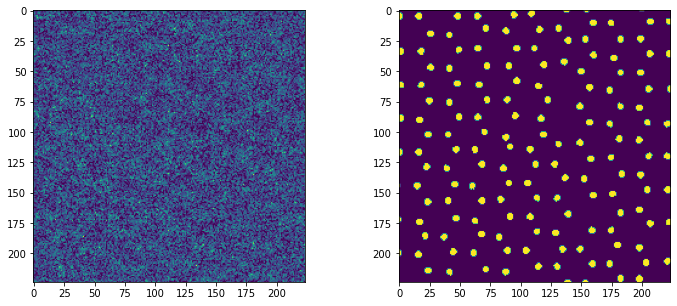

In [29]:
if add_noise:
    k = 600
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(X_train[k, 0])
    ax2.imshow(y_train[k,0])

In [30]:
#show model architecture. 
#Note that the architecture of this model should be identical to the model to be trained in the next cell 
#to ensure appropriate use of 'baseline approach'.
smodel

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stri

Train a new ensemble from scratch using experimental images as training data:

Downloading...
From: https://drive.google.com/uc?id=1flz1V6xj7dt2oYOgcYuT3ocVUtByvsvW
To: /content/graphene_elit_00_2b_ensemble.tar
482MB [00:06, 80.0MB/s]
Training ensemble models (strategy = 'from_scratch')

Ensemble model 1
Epoch 1/1 ... Training loss: 0.8452 ... Test loss: 0.6873 ... GPU memory usage: 13365/16160
Model (final state) evaluation loss: 0.6871
Plotting training history


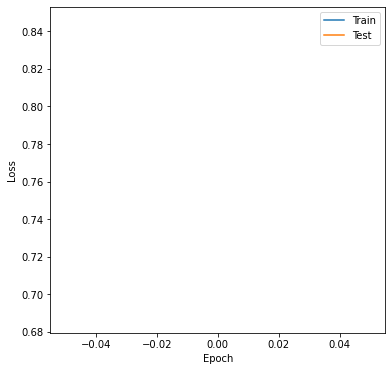


Ensemble model 2
Epoch 1/1 ... Training loss: 0.8739 ... Test loss: 0.6966 ... GPU memory usage: 13383/16160
Model (final state) evaluation loss: 0.6955
Plotting training history


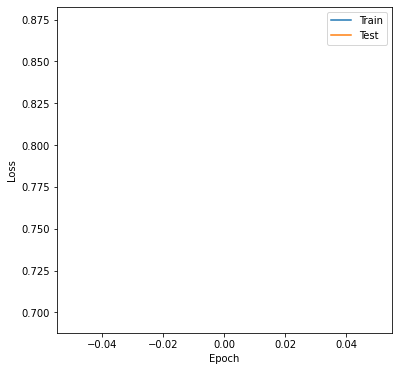


Ensemble model 3
Epoch 1/1 ... Training loss: 0.9059 ... Test loss: 0.6805 ... GPU memory usage: 13383/16160
Model (final state) evaluation loss: 0.6811
Plotting training history


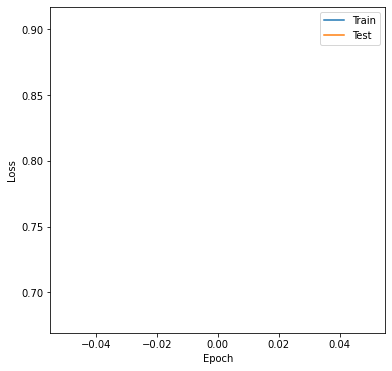


Ensemble model 4
Epoch 1/1 ... Training loss: 0.9072 ... Test loss: 0.6867 ... GPU memory usage: 13383/16160
Model (final state) evaluation loss: 0.6878
Plotting training history


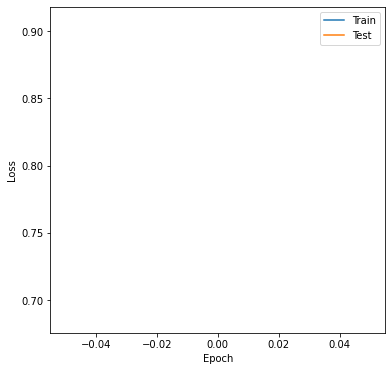


Ensemble model 5
Epoch 1/1 ... Training loss: 0.861 ... Test loss: 0.677 ... GPU memory usage: 13383/16160
Model (final state) evaluation loss: 0.6778
Plotting training history


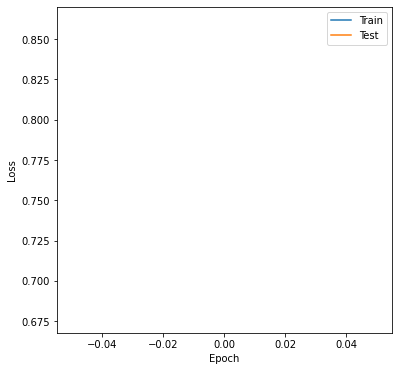


Ensemble model 6
Epoch 1/1 ... Training loss: 0.8769 ... Test loss: 0.6912 ... GPU memory usage: 13383/16160
Model (final state) evaluation loss: 0.6907
Plotting training history


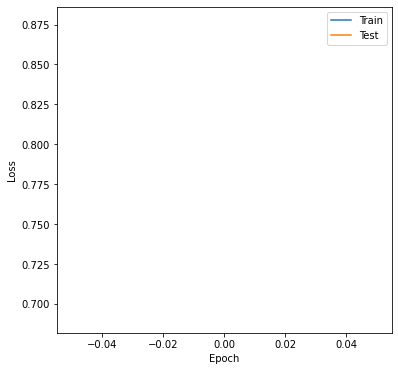

In [31]:
train_new = False

if train_new:
  etrainer = aoi.trainers.EnsembleTrainer("Unet", nb_classes=1, with_dilation=False,
                                      batch_norm=True, nb_filters=64, layers=[2, 3, 3, 4])
  etrainer.compile_ensemble_trainer(training_cycles=2000,compute_accuracy=True, swa=True, memory_alloc=0.5)
  smodel, ensemble = etrainer.train_ensemble_from_scratch(X_train, y_train, n_models=6)

else:
  !gdown https://drive.google.com/uc?id=1flz1V6xj7dt2oYOgcYuT3ocVUtByvsvW
  #!gdown https://drive.google.com/uc?id=1-NIrUImUevBl1pGor4z0fudpb7qomIQk
  #!wget -O graphene_elit_00_2b_ensemble.tar https://www.dropbox.com/s/f53gfgdg4fkoufz/graphene_elit_00_2b_ensemble.tar?dl=0
  
  #Adapt to the Atom AI new version

  # Initalize ensemble trainer and do a "fake" training for just 1 iteration using the newest atomai version

  etrainer = aoi.trainers.EnsembleTrainer("Unet", nb_classes=1, with_dilation=False,
                                        batch_norm=True, nb_filters=64, layers=[2, 3, 3, 4])

  etrainer.compile_ensemble_trainer(training_cycles=1,batch_size=12)

  smodel, ensemble = etrainer.train_ensemble_from_scratch(X_train, y_train, n_models=6, filename="/content/new0")


  # Load weights from the old model and put into the new ensemble format

  ensemble_old = torch.load("graphene_elit_00_2b_ensemble.tar")["weights"]

  for i in range(len(ensemble)):
      ensemble[i] = ensemble_old[i]

  etrainer.save_ensemble_metadict()

  # load back the ensemble with new weigths:
  smodel_00, ensemble_00 = aoi.models.load_ensemble("/content/new0_ensemble_metadict.tar")

Prediction with the re-trained ensemble:

In [32]:
# Initialize predictor
p = aoi.predictors.EnsemblePredictor(smodel_00,ensemble_00,nb_classes=1)

Batch 1/1

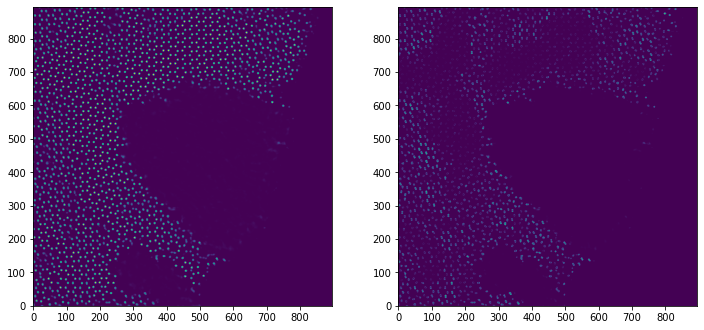

In [33]:
# prediction with uncertainty on individual frame
k = 90

img_mean, img_var = p.predict(imgdata[k:k+1])
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))
ax1.imshow(img_mean[0,...,0], origin="lower")
ax2.imshow(img_var[0,...,0], origin="lower")

Make a prediction on the entire set using the ensemble trained from baseline:

In [34]:
decoded_imgs_all = []
decoded_var_all = []

for i in range(imgdata.shape[0]):
  decode_img_loc, decode_var_loc = p.predict(imgdata[i:i+1])
  decoded_imgs_all.append(decode_img_loc)
  decoded_var_all.append(decode_var_loc)
  torch.cuda.empty_cache()

Batch 1/1

In [35]:
len(decoded_imgs_all)

100

In [36]:
decoded_imgs_all = np.array(decoded_imgs_all)
decoded_imgs_all = np.reshape(decoded_imgs_all,(100,896,896,1))
decoded_var_all = np.array(decoded_var_all)

In [37]:
Locator = aoi.predictors.predictor.Locator

In [38]:
coordinates = Locator(threshold = 0.33).run(decoded_imgs_all)

View results for selected frames:

Text(0.5, 1.0, 'Original Frame 0')

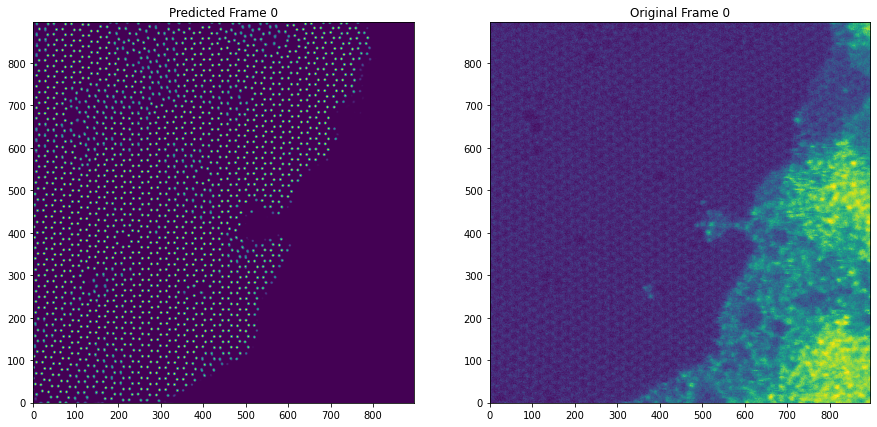

In [39]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(decoded_imgs_all[0,...,0], origin="lower")
ax1.set_title('Predicted Frame 0')
ax2.imshow(imgdata[0,...], origin="lower")
ax2.set_title('Original Frame 0')

## Iterative training 01: Multi-class classification (lattice + impurities)

Create ground truth for training using multiclass (C atom vs. point impurities vs everything else) data.

Note that GMM classification isn’t necessary here since the phases are already separated.

Hence we only update atomic/defect classes based on the calculated intensities at each predicted position or local neighborhood analysis based on subimages cropped around each predicted position.

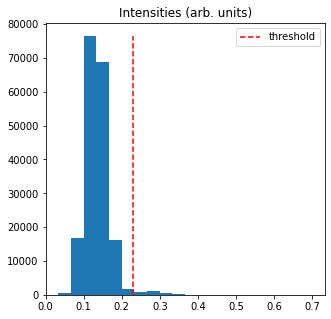

In [ ]:
#update coordinates class
coordinates = aoi.stat.update_classes(
    coordinates, imgdata, method="threshold",window_size=48, thresh=0.23) # other methods: kmeans, meanshift, gmm_local

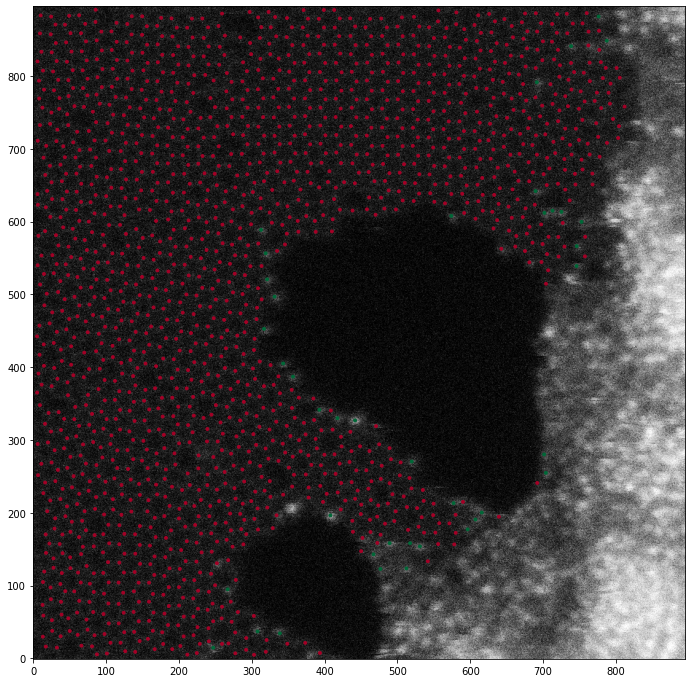

In [ ]:
k = 75 # frame number
aoi.utils.plot_coord(imgdata[k, ...], coordinates[k], fsize=12)

Prepare ground truth for training using multiclass lattice masks:

In [ ]:
# multiclass masks
masks = aoi.utils.create_multiclass_lattice_mask(imgdata, dc(coordinates))

In [ ]:
masks.shape

(100, 896, 896, 3)

In [ ]:
# # "masks"
window_size = 224
masks_cropped, _, frames1 = aoi.utils.extract_subimages(
    masks, coordinates, window_size, 1)

In [ ]:
# # images
window_size = 224
images_cropped, _, frames2 = aoi.utils.extract_subimages(
    imgdata, coordinates, window_size, 1)

In [ ]:
X_train, y_train = aoi.transforms.squeeze_channels(images_cropped, masks_cropped)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(2467, 224, 224)
(2467, 224, 224)


Visualize training data and multi-class segmentation masks:

Text(0.5, 1.0, 'Frame_25')

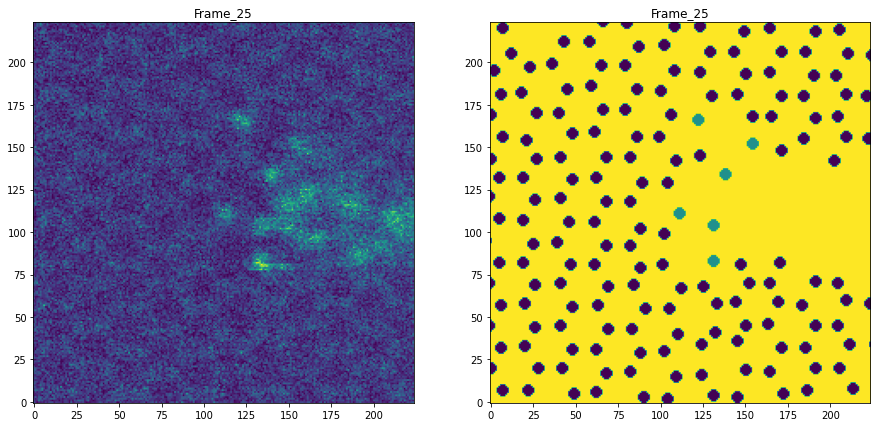

In [ ]:
k = 25

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(X_train[k,:,:], origin="lower")
ax1.set_title('Frame_{}'.format(k))
ax2.imshow(y_train[k,:,:], origin="lower")
ax2.set_title('Frame_{}'.format(k))

In [ ]:
add_noise = True

if add_noise:

    dt = aoi.transforms.datatransform(3, # number of classes
                                      "channel_first",
                                      "channel_first",
                                      gauss_noise=[0, 100], # scaled values
                                      #contrast=True,
                                      zoom=1.1,
                                      rotation=True,
                                      squeeze_channels=True,
                                      seed=1)

    X_train, y_train = dt.run(X_train, aoi.transforms.unsqueeze_channels(y_train, 3))

Train a new ensemble of multi-class models:

Downloading...
From: https://drive.google.com/uc?id=1--0oL9K_k-1R6YgbqvK6MNdFYSG4OK2R
To: /content/graphene_elit_01_2b_ensemble.tar
590MB [00:03, 150MB/s]
Training ensemble models (strategy = 'from_scratch')

Ensemble model 1
Epoch 1/1 ... Training loss: 1.6054 ... Test loss: 1.0907 ... GPU memory usage: 13131/16280
Model (final state) evaluation loss: 1.0903
Plotting training history


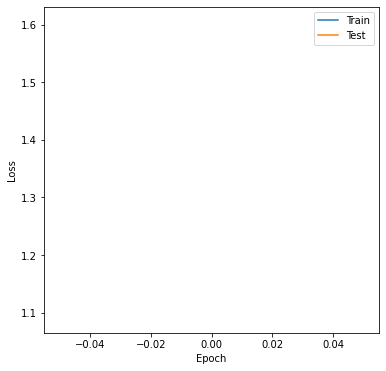


Ensemble model 2
Epoch 1/1 ... Training loss: 1.5551 ... Test loss: 1.0785 ... GPU memory usage: 13145/16280
Model (final state) evaluation loss: 1.0779
Plotting training history


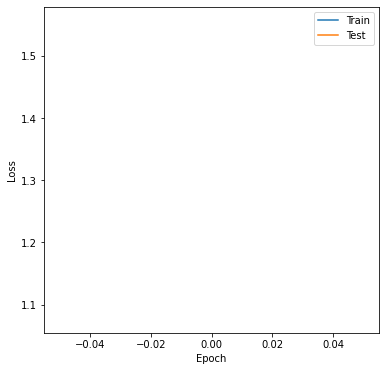


Ensemble model 3
Epoch 1/1 ... Training loss: 1.5136 ... Test loss: 1.0818 ... GPU memory usage: 13149/16280
Model (final state) evaluation loss: 1.0816
Plotting training history


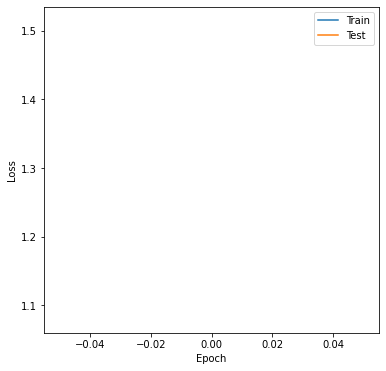


Ensemble model 4
Epoch 1/1 ... Training loss: 1.5821 ... Test loss: 1.1367 ... GPU memory usage: 13205/16280
Model (final state) evaluation loss: 1.1369
Plotting training history


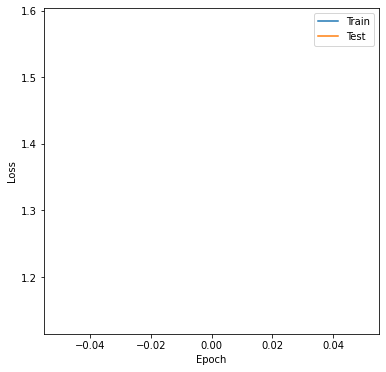


Ensemble model 5
Epoch 1/1 ... Training loss: 1.5379 ... Test loss: 1.1019 ... GPU memory usage: 13249/16280
Model (final state) evaluation loss: 1.1019
Plotting training history


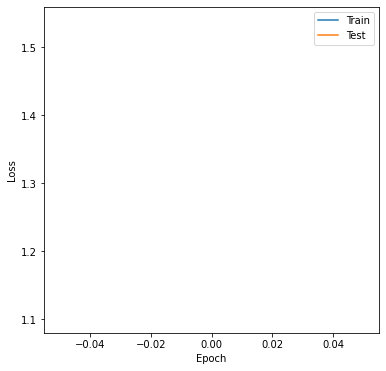


Ensemble model 6
Epoch 1/1 ... Training loss: 1.5673 ... Test loss: 1.0942 ... GPU memory usage: 13305/16280
Model (final state) evaluation loss: 1.0947
Plotting training history


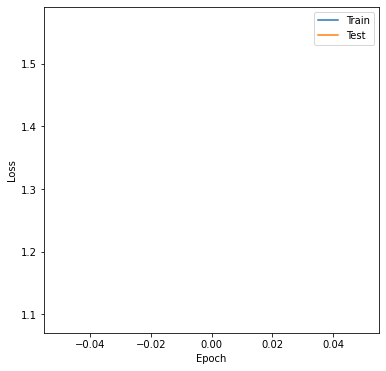


Ensemble model 7
Epoch 1/1 ... Training loss: 1.502 ... Test loss: 1.0939 ... GPU memory usage: 13349/16280
Model (final state) evaluation loss: 1.0944
Plotting training history


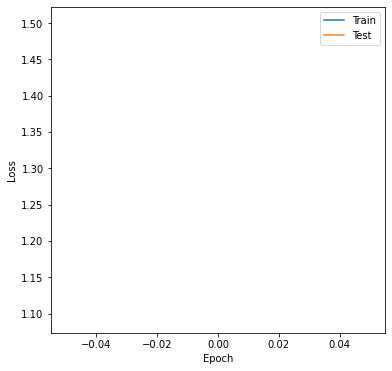


Ensemble model 8
Epoch 1/1 ... Training loss: 1.6114 ... Test loss: 1.0932 ... GPU memory usage: 13405/16280
Model (final state) evaluation loss: 1.0937
Plotting training history


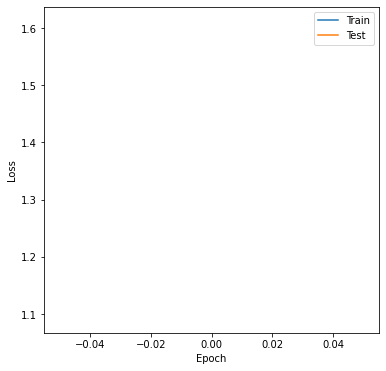

In [ ]:
train_new = False

if train_new:
  etrainer = aoi.trainers.EnsembleTrainer("Unet", nb_classes=1, with_dilation=False,
                                      batch_norm=True, nb_filters=64, layers=[2, 3, 3, 4])
  etrainer.compile_ensemble_trainer(training_cycles=2000,compute_accuracy=True, swa=True, memory_alloc=0.5)
  smodel, ensemble = etrainer.train_ensemble_from_scratch(X_train, y_train, n_models=6)

else:
  !gdown https://drive.google.com/uc?id=1--0oL9K_k-1R6YgbqvK6MNdFYSG4OK2R
  #!gdown https://drive.google.com/uc?id=1e03u0vkDQUEFgm5oFj1m4kKvncBdEJ-l
  #!wget -O graphene_elit_01_2b_ensemble.tar https://www.dropbox.com/s/so1kwd4aj1v6exn/graphene_elit_01_2b_ensemble.tar?dl=0
  
  #Adapt to the Atom AI new version

  # Initalize ensemble trainer and do a "fake" training for just 1 iteration using the newest atomai version

  etrainer = aoi.trainers.EnsembleTrainer("Unet", nb_classes=3, with_dilation=False,
                                        batch_norm=True, nb_filters=64, layers=[2, 3, 3, 4])

  etrainer.compile_ensemble_trainer(training_cycles=1,batch_size=12)

  smodel, ensemble = etrainer.train_ensemble_from_scratch(X_train, y_train, n_models=8, filename="/content/new1")

  # Load weights from the old model into the new one

  ensemble_old = torch.load("graphene_elit_01_2b_ensemble.tar")["weights"]

  for i in range(len(ensemble)):
      ensemble[i] = ensemble_old[i]

  etrainer.save_ensemble_metadict()

  # load back the ensemble with new weigths:
  smodel_01, ensemble_01 = aoi.models.load_ensemble("/content/new1_ensemble_metadict.tar")

Prediction with the re-trained ensemble:

In [ ]:
# Initialize predictor
p = aoi.predictors.EnsemblePredictor(smodel_01,ensemble_01,nb_classes=3)

Inspect predictions and associated uncertainty on different images:

Batch 1/1

Text(0.5, 1.0, "Uncertainty: Class 'Si'")

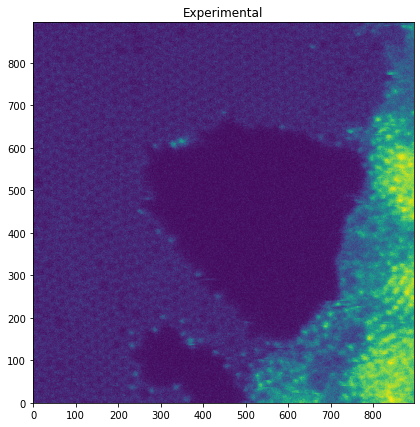

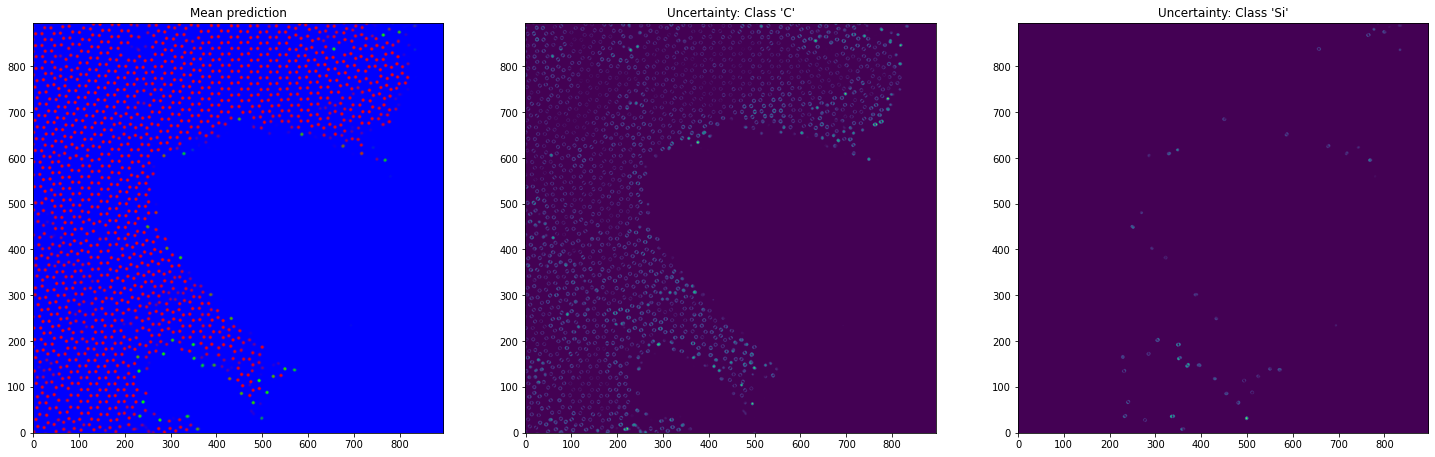

In [ ]:
k = 90

decoded_imgs, decoded_var = p.predict(imgdata[k:k+1], num_batches=20)

plt.figure(figsize=(7, 7))
plt.imshow(imgdata[k], origin="lower")
plt.title("Experimental")
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
ax1.imshow(decoded_imgs[0], origin="lower")
ax1.set_title("Mean prediction")
ax2.imshow(decoded_var[0,...,0], origin="lower")
ax2.set_title("Uncertainty: Class 'C'")
ax3.imshow(decoded_var[0,...,1], origin="lower")
ax3.set_title("Uncertainty: Class 'Si'")